# Initial EDA of CMI competition dataset

The data analysis is done using the incomplete dataset given for the competition. It will not contain the imputed dataset that was created by the code in the data_prep.py file.
For createing the final dataset used for training the gradient boosting algorithms several methods were implemented:
- The categorical values were imputed using the Simple Imputer and filling empty values with the most frequent value.
- The numerical values were imputed using the Iterative Imputer with an Extra Tree Rgressor as an estimator.
- The outliers were detected and deleted using an Isolation Forest.
- An RFE selector was used to select the best features.
- Various features extracted from the actigraphy files were also included to the above processes.

### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read data and print basic information

In [3]:
df = pd.read_csv("./data/train.csv")

print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print("Feature names:", df.columns)

# Classify each feature
string_categorical_features = df.select_dtypes(include = 'object').columns.to_list()

continuous_features = ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND',
                       'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 
                       'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat',
                       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'
                     ]

categorical_int_features = ['Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone',
                            'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday']

target_features = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
       'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']

print("Categorical features containing strings:", string_categorical_features)
print("Categorical features containing integers:", categorical_int_features)
print("Continuous features: ", continuous_features)
print("Target features: ", target_features)

Number of rows: 3960
Number of columns: 82
Feature names: Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Fram

### Missing values

As we can see most of the features have a big amount of missing values. This makes data Imputation necessary. 30% of the target feature are also NA values which obliges us to either delete them from the dataset or use unsupervised learning methods.

<Figure size 1500x1000 with 0 Axes>

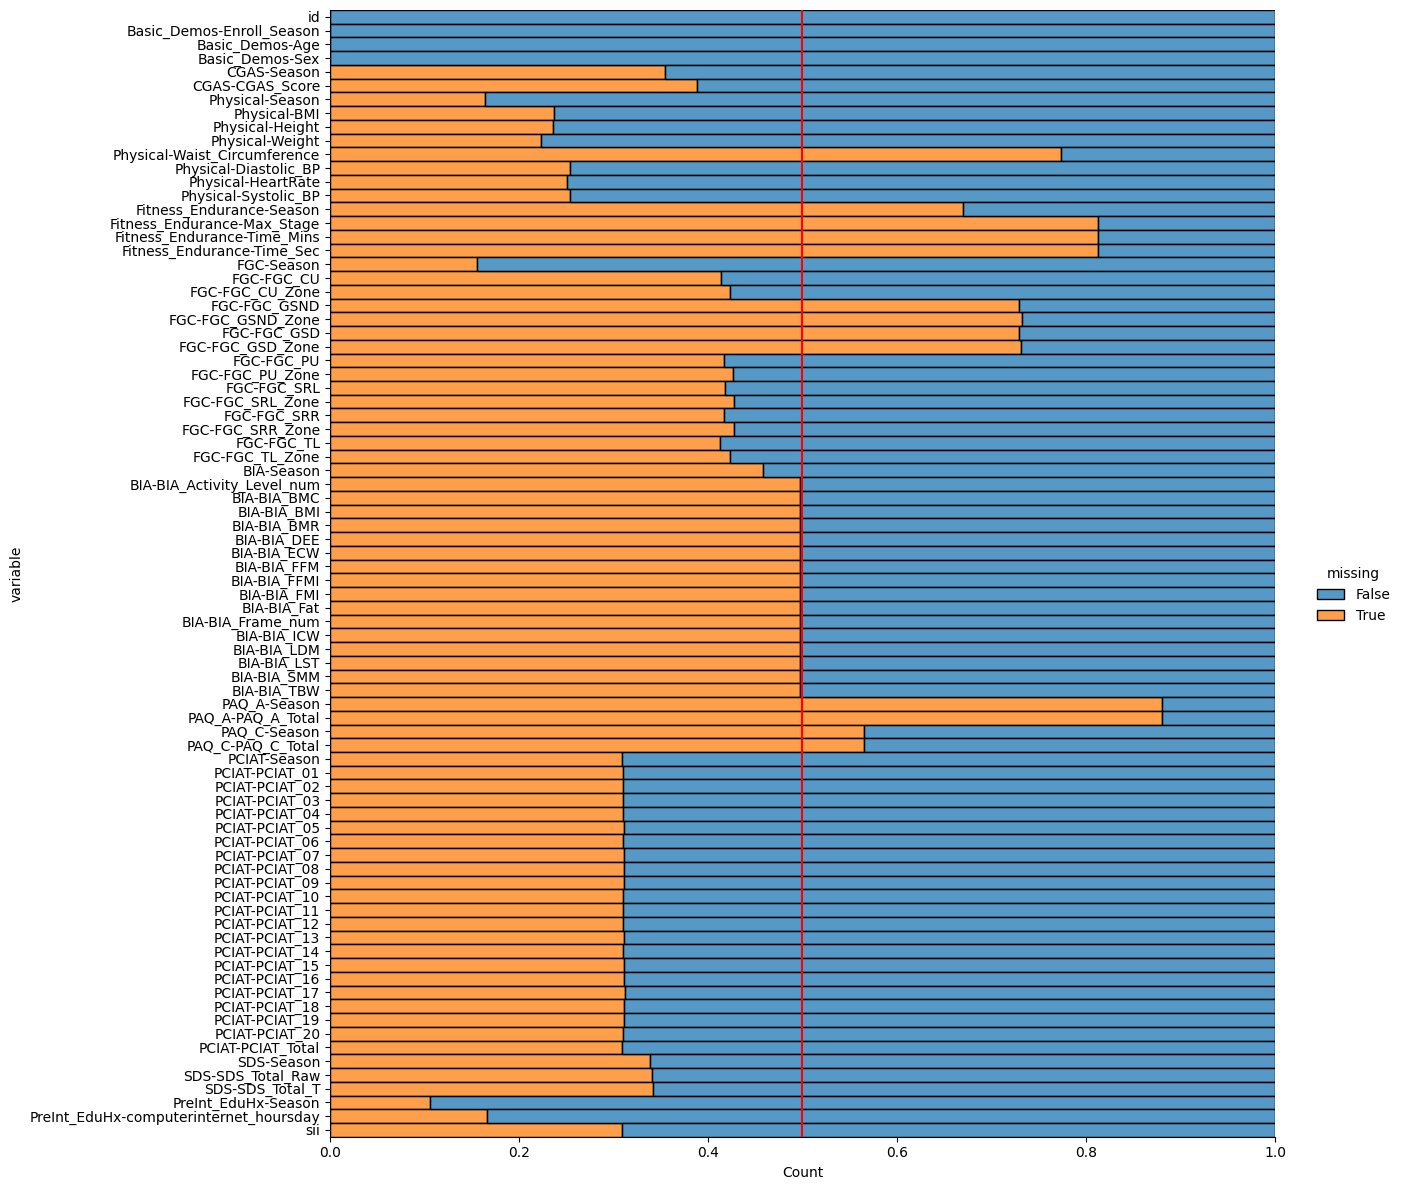

In [4]:
# Create a dictionary with the column name and the percentage of missing values
missing_values_dict = {col: np.round(np.mean(df[col].isnull()*100)) for col in df.columns if df[col].isnull().any()}

# Uncomment if you want to see the percentage of missing values
# for k,v in missing_values_dict.items():
#     print(f"{k}: {v}%")

# Plot the missing values
plt.figure(figsize=(15,10))
sns.displot(
    data=df.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=12,
    aspect=1.1
)

# specifying a threshold value
plt.axvline(0.5, color='r')

### Probability distribution of features

By looking at the distributions of our features we can immidiately spot that a lot of features have outliers that are way off the nomral distribution. Honestly they don't even look like real data but numerical errors.
Also, even though these features are continuous, a lot of them lack values in specific ranges. Now this is caused mostly by the missing values in the dataset and the nature of the features. 
Finally, most of the features do not have normal distributions.

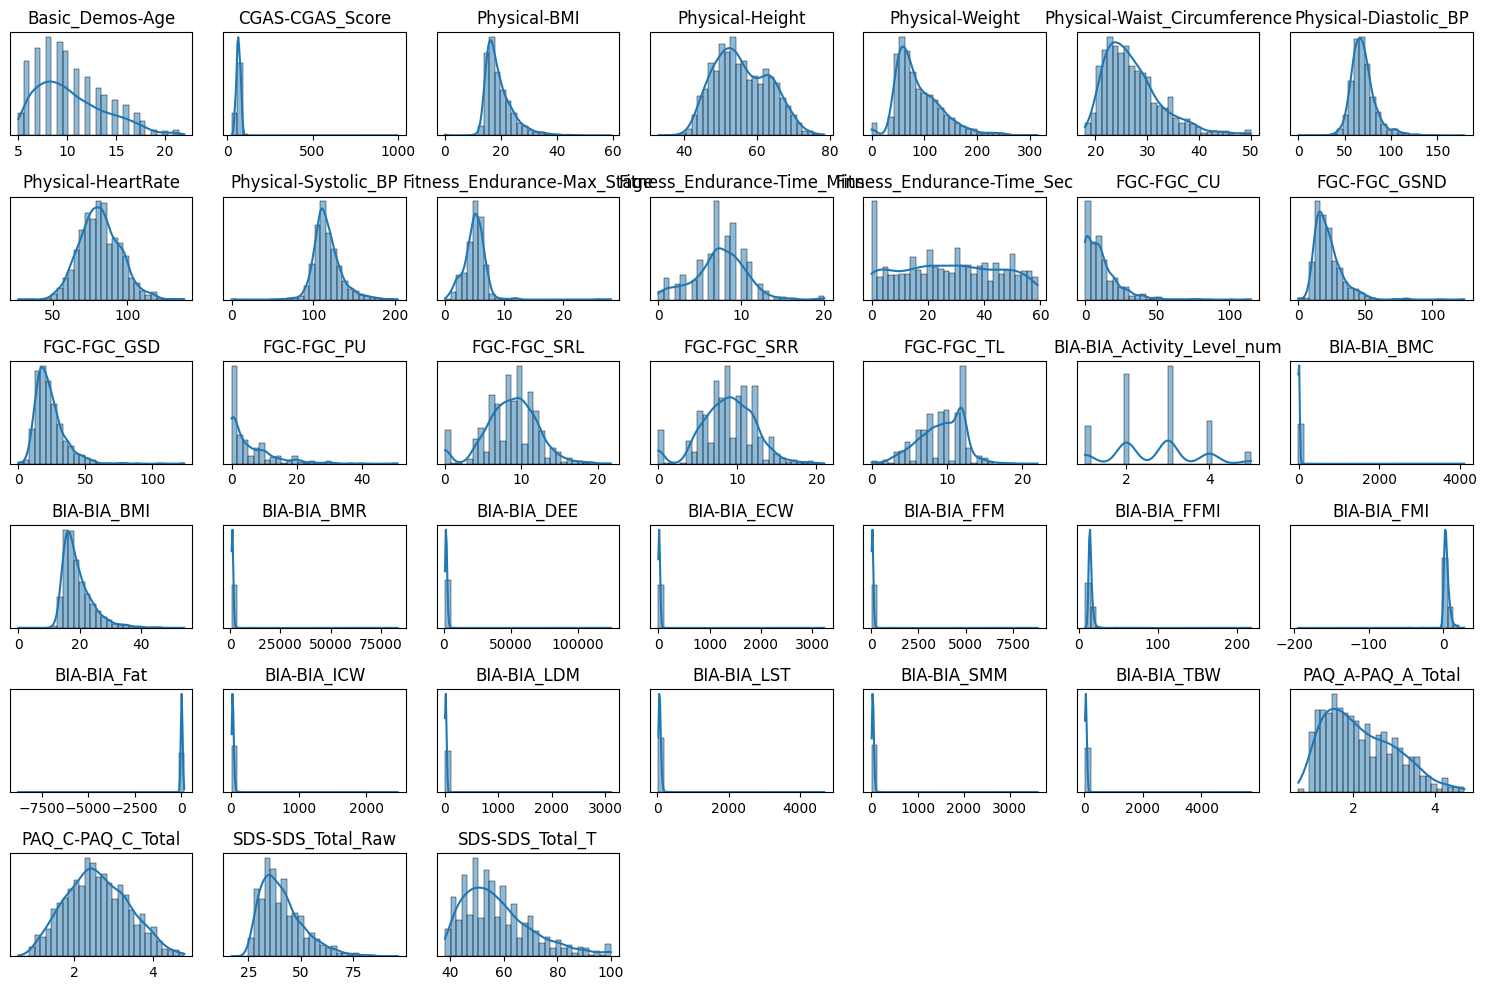

In [5]:
cont_df = df[continuous_features].copy()

plt.figure(figsize=(15, 10))  

for i, col in enumerate(cont_df.columns, 1):
    plt.subplot(6, 7, i)  
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("")
    plt.yticks([])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Class distribution

There is an over representation of zero sii values and under representation of the extreme values of the target that will almost certainly lead to the model becoming biased.

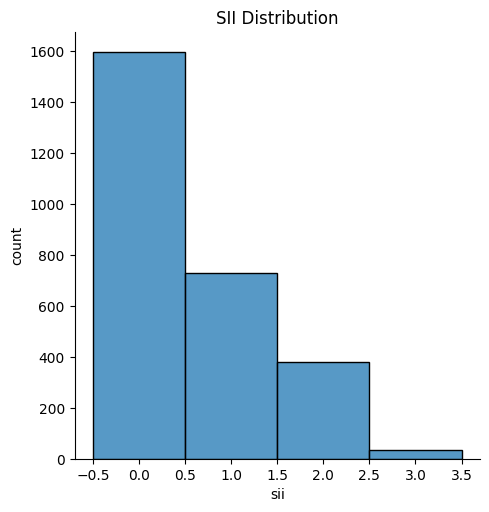

In [6]:
sns.displot(data=df['sii'], bins=4, discrete=True)
plt.title("SII Distribution")
plt.xlabel("sii")
plt.ylabel("count")
plt.show()

### Correlation map

Correlation matrix show a lot of features that are highly correlated with each other. High corellations between features does not necessarily lead to increased accuracy of the model. On the contrary, it might be better to drop some of these features in order to make our model simpler. This is based on the minimum discreption length principle which is a mathematical implementation of the Ocams razor. We could also try combining some of these features. 

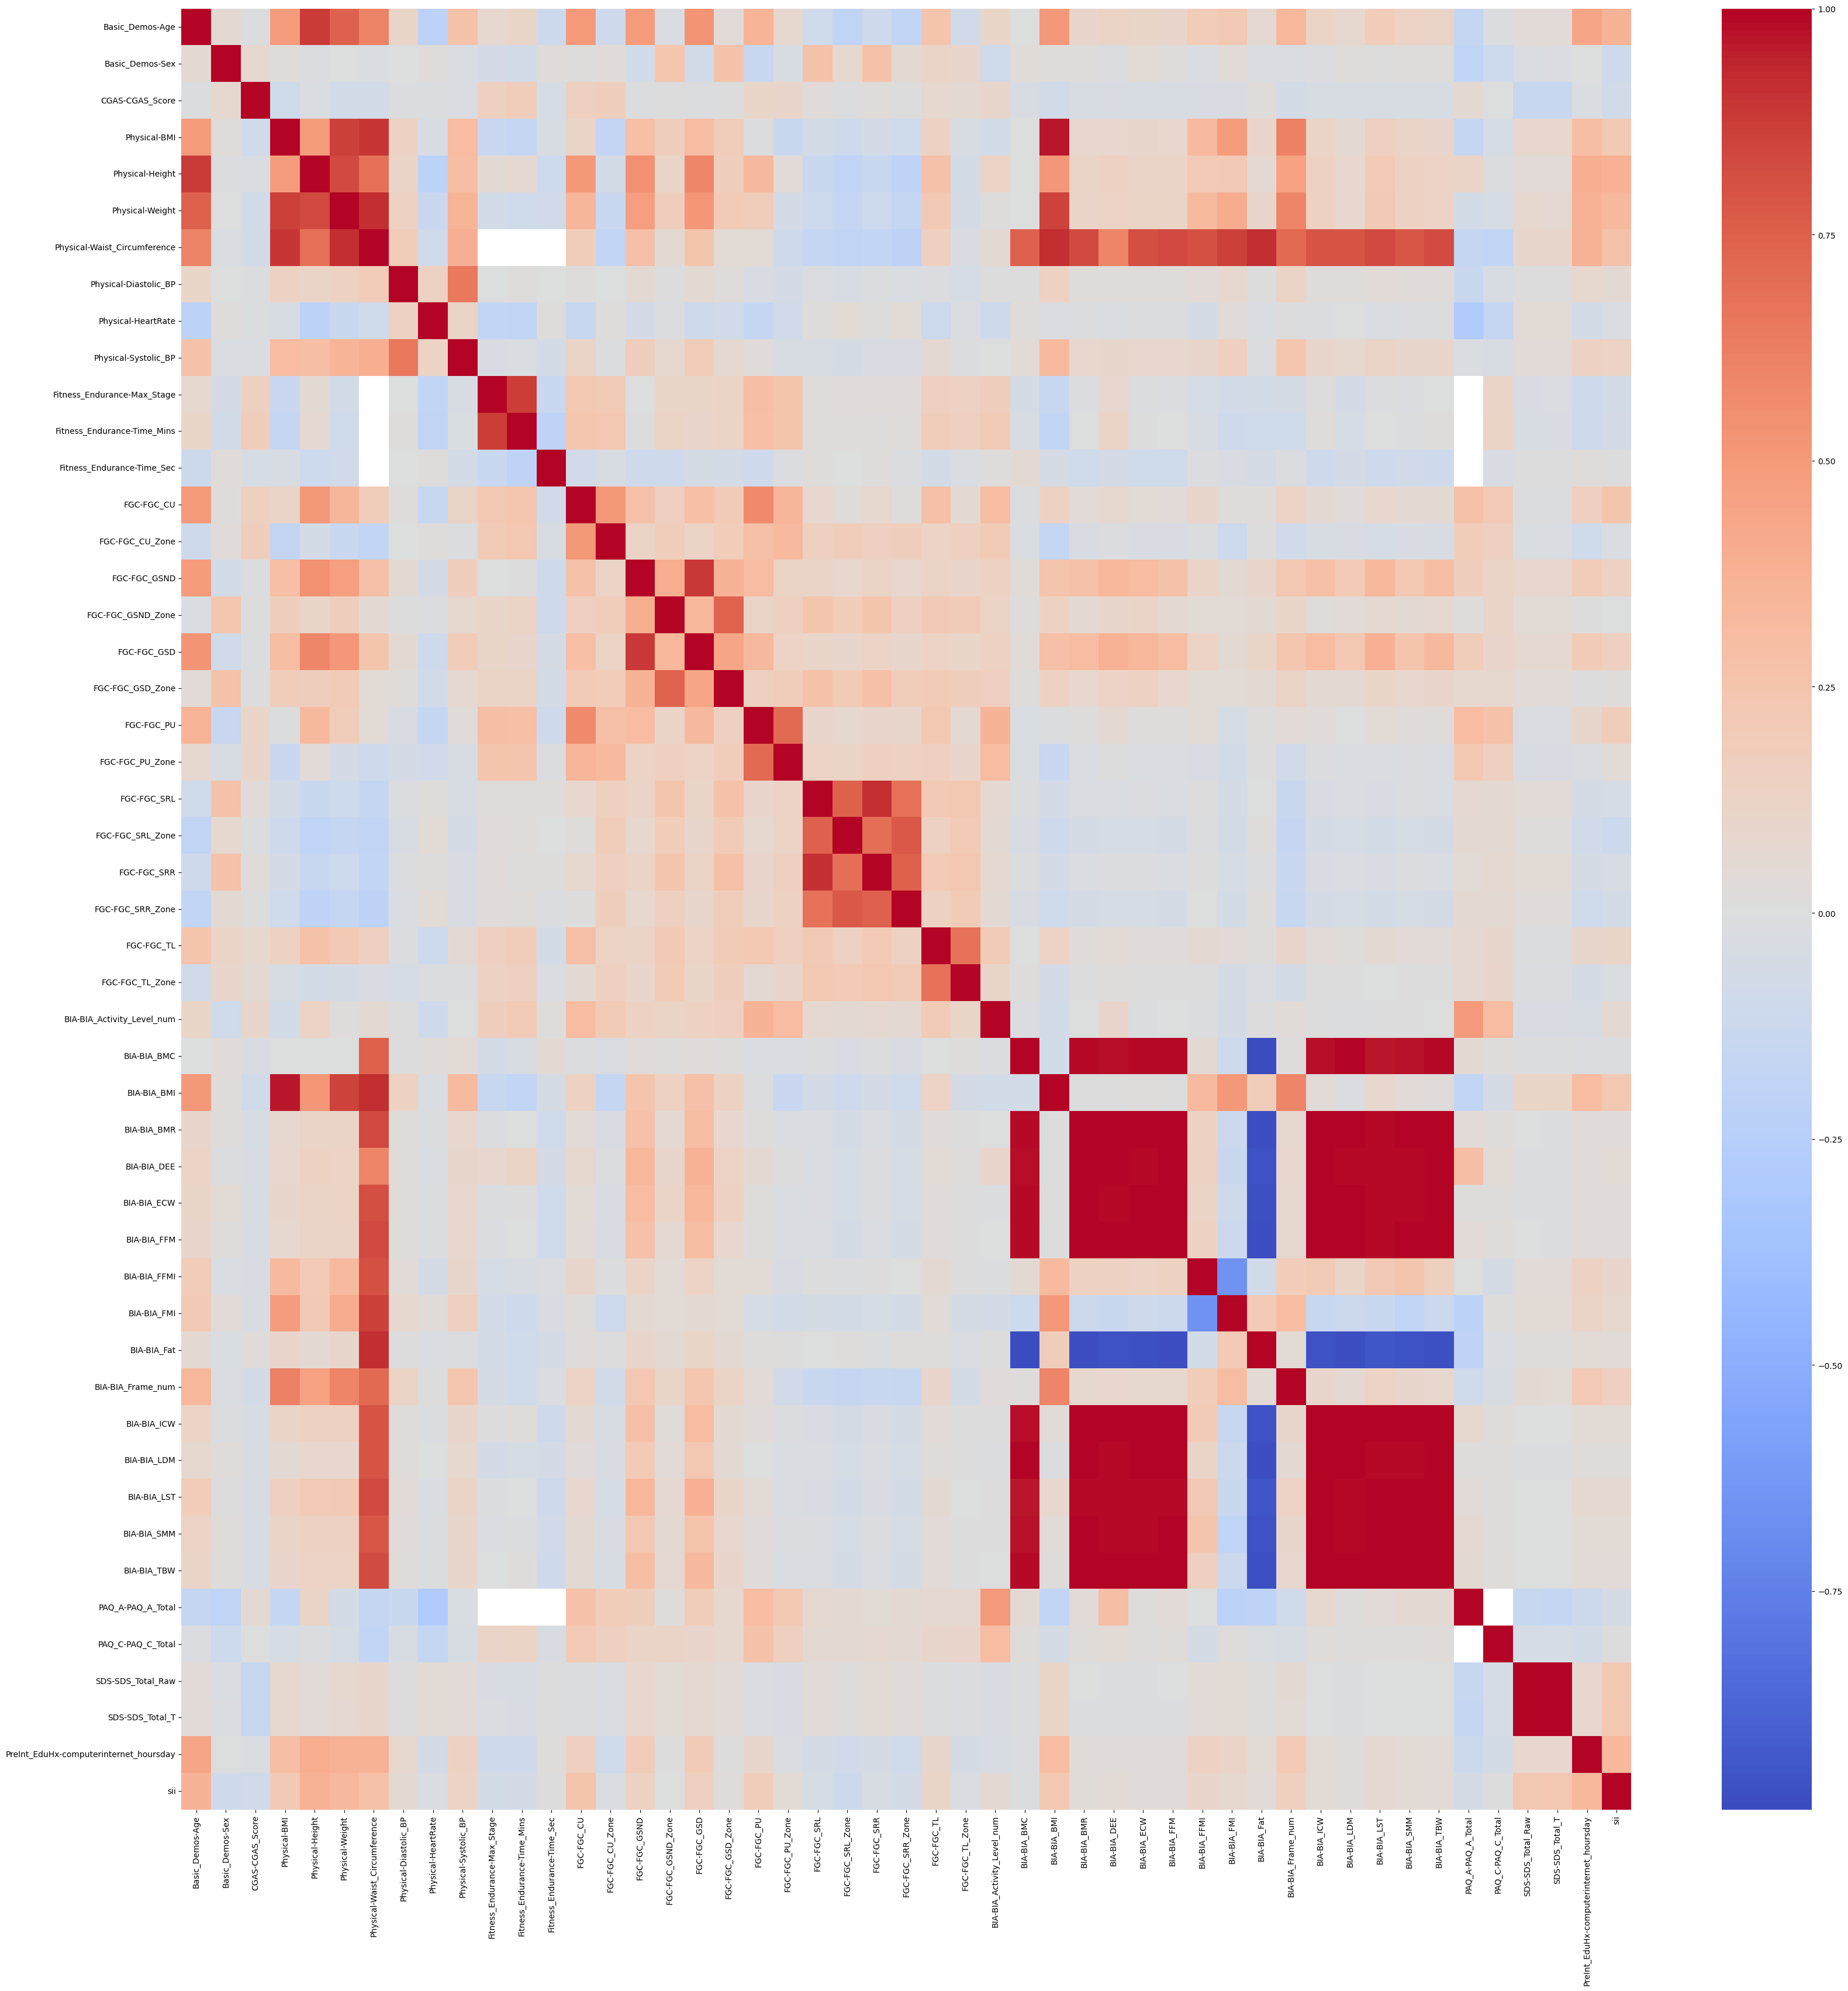

In [7]:
features = df.drop(columns=['id'] + target_features[:-1])  
correlation = features.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(40,40))
sns.heatmap(correlation, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.show()

### Label Box Plot

Box plots are a great way to visualize the distribution of a single feature and the spread of the data. They also provide information about the presence of outliers and the potential skewness of the data. In our case, we can see that most of the features have outliers.

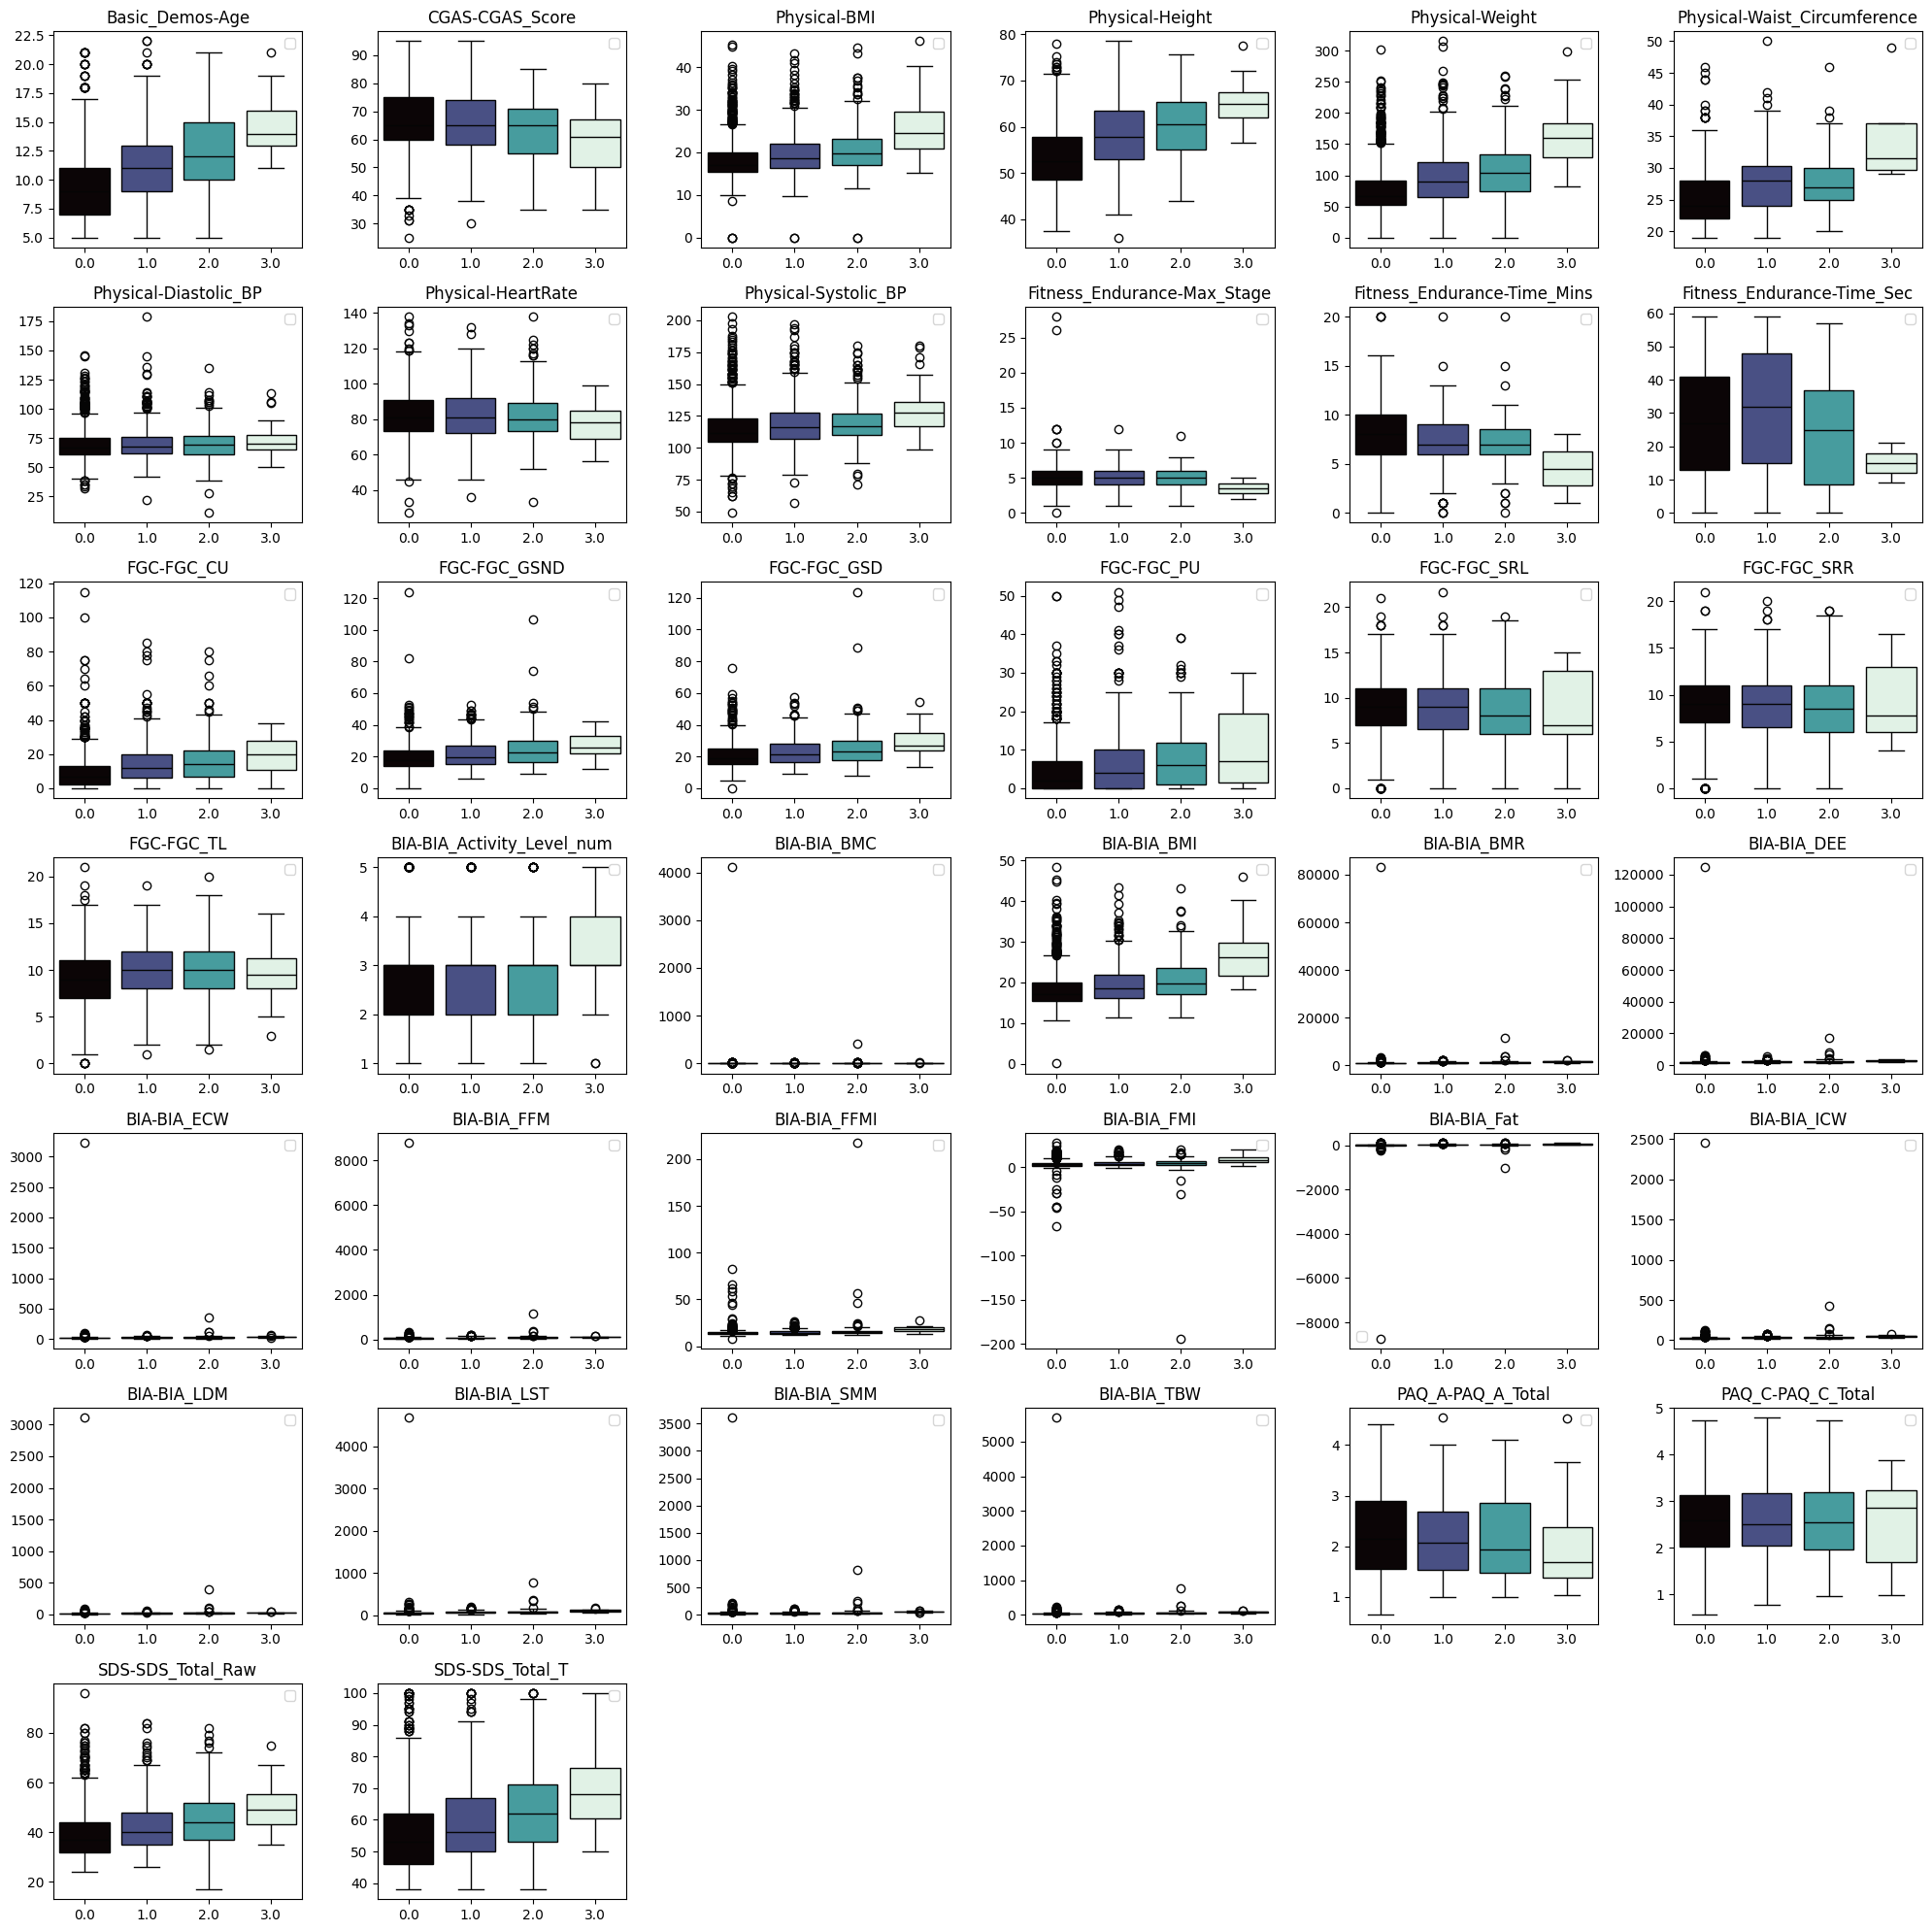

In [14]:
plt.figure(figsize=(20,20))
for i, col in enumerate(cont_df.columns, 1):
    plt.subplot(7, 6, i)
    sns.boxplot(data=df, x=df['sii'], y=df[f'{col}'], hue='sii', palette=sns.color_palette('mako', as_cmap=True))
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("")
    plt.legend([])

plt.tight_layout()
plt.show()
    
    